# EXPERIMENT 5: Trying different architectures

In [1]:
import torch 
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.ops import nms
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
from dataset import AfricanWildlifeDataset
from loss import YoloLoss
from YOLOv1 import YOLO
from train import train
from test import test
from utils import plot_bbox, compute_ap, get_boxes
import time

def convert_dict(d, with_score=True):
    boxes_by_img = []
    for key, val in d.items():
        l = {}
        l['boxes'] = torch.tensor([x[2:] for x in val])
        if with_score:
            l['scores'] = torch.tensor([x[1] for x in val])
        l['labels'] = torch.tensor([int(x[0]) for x in val])
        boxes_by_img.append(l)
    return boxes_by_img

In [3]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
TRAIN_BATCH_SIZE = 20
TEST_BATCH_SIZE = 5
EPOCHS = 0
TRAIN_DIR = 'African_Wildlife/train'
TEST_DIR = 'African_Wildlife/test'
LABEL_DIR = 'African_Wildlife/annotations'
S, B, C = 3, 2, 4

In [4]:
# load the data
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor(), transforms.Normalize([0.5200, 0.4957, 0.4068],[0.2391, 0.2283, 0.2303])])

train_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, S=S, B=B, C=C, transform=transform)
train_loader = DataLoader(dataset = train_set, batch_size = TRAIN_BATCH_SIZE, shuffle = True)

test_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, S=S, B=B, C=C, istesting=True, transform=transform)
test_loader = DataLoader(dataset=test_set, batch_size=TEST_BATCH_SIZE, shuffle= False)

# DARKNET 19

In [5]:
# model
model = YOLO(input_channels=3, S=S, B=B, C=C, arch="darknet19").to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = YoloLoss(S=S, B=B, C=C)

In [9]:
# training 
loss_hist1 = train(train_loader, model, optimizer, criterion, EPOCHS, DEVICE, 
                  ckpt_filename='experiment_5/darknet19.tar', load_model=True, save_epochs=5)

-> Loading checkpoint


UnboundLocalError: local variable 'epoch' referenced before assignment

In [8]:
# plot training loss
plt.plot(range(len(loss_hist1)), loss_hist1)
plt.xlabel("Epoch")
plt.ylabel("Loss")

NameError: name 'loss_hist1' is not defined

In [10]:
# testing 
y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[0.6, True])
# non-max-suppression
pred_boxes, true_boxes = get_boxes(y_pred, y_true)

pred = {}
pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in pred_boxes:
    pred[box[0]].append(box[1:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

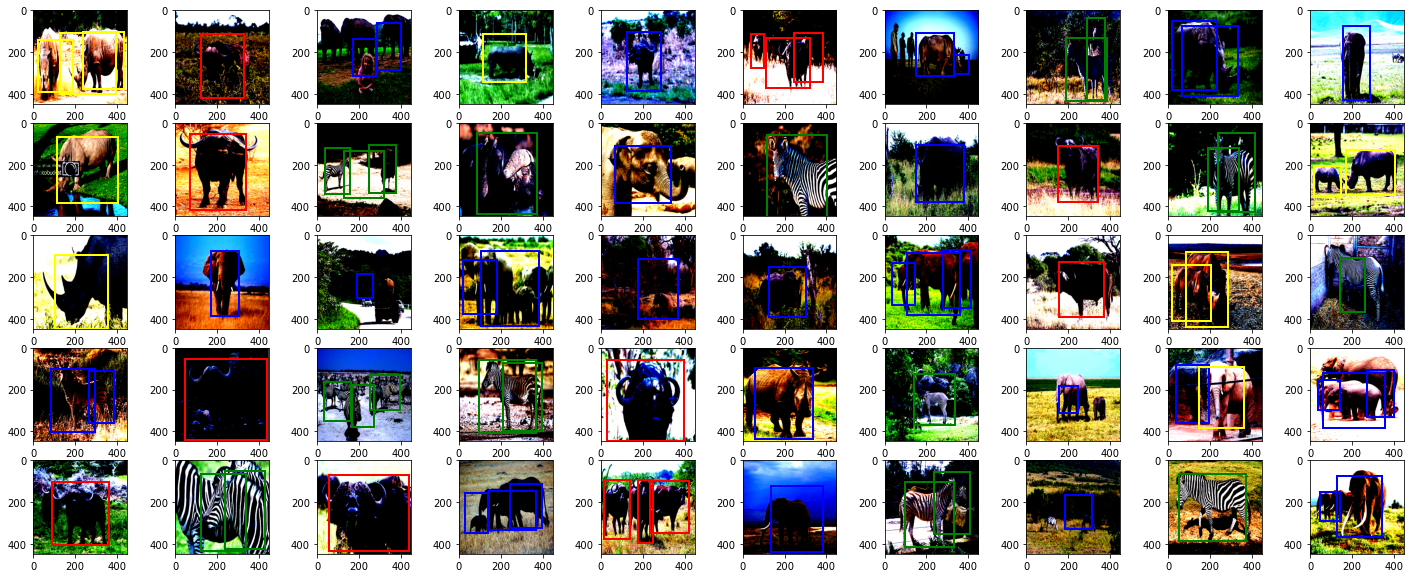

In [11]:
# plot predictions
fig, ax = plt.subplots(5, 10, figsize=(25, 10))
for idx in range(50):
    bbx = pred[idx]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

In [12]:
# map
gt = {}
gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in true_boxes:
    gt[box[0]].append(box[1:])
    
predictions = convert_dict(pred)
target = convert_dict(gt, with_score=False)

th = torch.arange(0.5, 1, 0.05).tolist()
m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)
m_ap.update(predictions, target)
ap1 = m_ap.compute()

In [13]:
ap1

{'map': tensor(0.1299),
 'map_50': tensor(0.3390),
 'map_75': tensor(0.0699),
 'map_small': tensor(0.1299),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.1867),
 'mar_10': tensor(0.2149),
 'mar_100': tensor(0.2149),
 'mar_small': tensor(0.2149),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

# DARKNET 53

In [45]:
# model
model = YOLO(input_channels=3, S=S, B=B, C=C, arch="darknet53").to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = YoloLoss(S=S, B=B, C=C)

In [46]:
# training 
loss_hist2 = train(train_loader, model, optimizer, criterion, EPOCHS, DEVICE, 
                  ckpt_filename='experiment_5/darknet53.tar', load_model=True, save_epochs=5)

-> Loading checkpoint


100%|██████████| 60/60 [00:30<00:00,  1.99it/s, loss=0.00604]


 EPOCH 1:  Mean loss 0.005


100%|██████████| 60/60 [00:29<00:00,  2.03it/s, loss=0.00581]


 EPOCH 2:  Mean loss 0.005


100%|██████████| 60/60 [00:29<00:00,  2.00it/s, loss=0.00408]


 EPOCH 3:  Mean loss 0.005


100%|██████████| 60/60 [00:30<00:00,  2.00it/s, loss=0.00465]


 EPOCH 4:  Mean loss 0.004


100%|██████████| 60/60 [00:29<00:00,  2.02it/s, loss=0.00348]


 EPOCH 5:  Mean loss 0.004
-> Saving checkpoint


100%|██████████| 60/60 [00:30<00:00,  2.00it/s, loss=0.00308]


 EPOCH 6:  Mean loss 0.004


100%|██████████| 60/60 [00:29<00:00,  2.02it/s, loss=0.00472]


 EPOCH 7:  Mean loss 0.003


100%|██████████| 60/60 [00:29<00:00,  2.01it/s, loss=0.003]  


 EPOCH 8:  Mean loss 0.003


100%|██████████| 60/60 [00:29<00:00,  2.02it/s, loss=0.00321]


 EPOCH 9:  Mean loss 0.004


100%|██████████| 60/60 [00:29<00:00,  2.00it/s, loss=0.00491]


 EPOCH 10:  Mean loss 0.004
-> Saving checkpoint


100%|██████████| 60/60 [00:29<00:00,  2.02it/s, loss=0.00507]


 EPOCH 11:  Mean loss 0.004


100%|██████████| 60/60 [00:29<00:00,  2.03it/s, loss=0.00332]


 EPOCH 12:  Mean loss 0.004


100%|██████████| 60/60 [00:29<00:00,  2.03it/s, loss=0.00352]


 EPOCH 13:  Mean loss 0.004


100%|██████████| 60/60 [00:29<00:00,  2.02it/s, loss=0.00408]


 EPOCH 14:  Mean loss 0.004


100%|██████████| 60/60 [00:29<00:00,  2.01it/s, loss=0.00478]


 EPOCH 15:  Mean loss 0.004
-> Saving checkpoint


100%|██████████| 60/60 [00:29<00:00,  2.03it/s, loss=0.00547]


 EPOCH 16:  Mean loss 0.004


100%|██████████| 60/60 [00:29<00:00,  2.03it/s, loss=0.0035] 


 EPOCH 17:  Mean loss 0.004


100%|██████████| 60/60 [00:29<00:00,  2.01it/s, loss=0.00302]


 EPOCH 18:  Mean loss 0.004


100%|██████████| 60/60 [00:29<00:00,  2.02it/s, loss=0.00322]


 EPOCH 19:  Mean loss 0.003


100%|██████████| 60/60 [00:29<00:00,  2.03it/s, loss=0.00361]


 EPOCH 20:  Mean loss 0.003
-> Saving checkpoint


Text(0, 0.5, 'Loss')

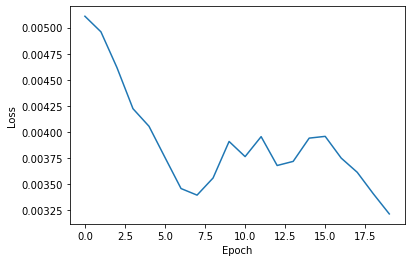

In [47]:
# plot training loss
plt.plot(range(len(loss_hist2)), loss_hist2)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [48]:
# testing 
y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[0.6, True])
# non-max-suppression
pred_boxes, true_boxes = get_boxes(y_pred, y_true)

pred = {}
pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in pred_boxes:
    pred[box[0]].append(box[1:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

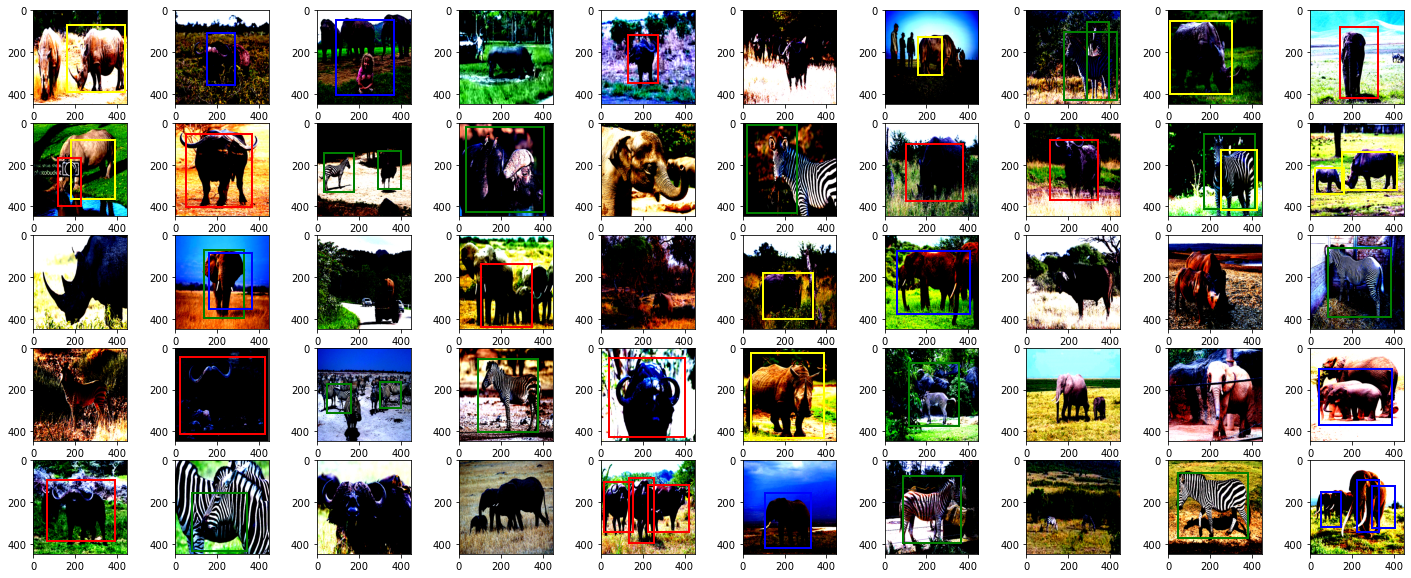

In [49]:
# plot predictions
fig, ax = plt.subplots(5, 10, figsize=(25, 10))
for idx in range(50):
    bbx = pred[idx]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

In [50]:
# map
gt = {}
gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in true_boxes:
    gt[box[0]].append(box[1:])
    
predictions = convert_dict(pred)
target = convert_dict(gt, with_score=False)

th = torch.arange(0.5, 1, 0.05).tolist()
m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)
m_ap.update(predictions, target)
ap2 = m_ap.compute()

In [51]:
ap2

{'map': tensor(0.1354),
 'map_50': tensor(0.2547),
 'map_75': tensor(0.1308),
 'map_small': tensor(0.1354),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.1534),
 'mar_10': tensor(0.1769),
 'mar_100': tensor(0.1769),
 'mar_small': tensor(0.1769),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [15]:
darknet19 = torch.load('experiment_5/darknet19.tar')
loss_history1 = darknet19["loss_history"]
epoch = darknet19["epoch"]

darknet53 = torch.load('experiment_5/darknet53.tar')
loss_history2 = darknet53["loss_history"]

epochs = [i for i in range(1,epoch+1)]

ValueError: x and y must have same first dimension, but have shapes (50,) and (20,)

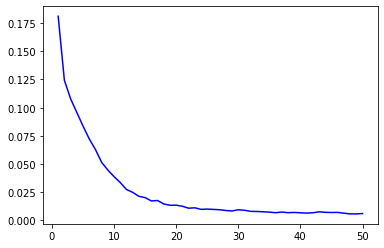

In [16]:
import matplotlib.pyplot as plt

plt.plot(epochs, loss_history1, 'b-', label='darkent19')
plt.plot(epochs, loss_history2, 'r-', label='darknet53')
plt.legend(loc='best')
plt.title('Loss Functions')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()